In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter 
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals 
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

# Classification

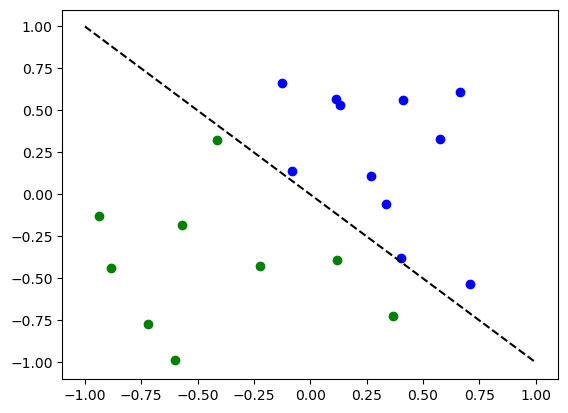

In [3]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0) # in {0,1}
y = 2 * y01 - 1 # in {-1, 1}
y_one_hat = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hat[i, y01[i]] = 1
    
for x, y_target in zip(X, y): 
    if y_target == 1: 
        plt.plot(x[0], x[1], "bo")
    else: 
        plt.plot(x[0], x[1], "go")
        
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## Classification with `EstimatorQNN`

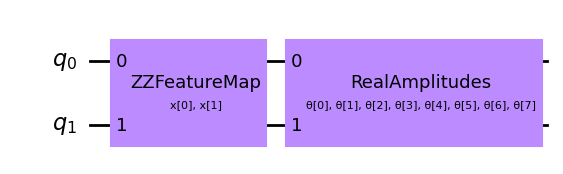

In [4]:
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [5]:
estimator_qnn = EstimatorQNN(circuit=qc)

In [7]:
# QNN maps inputs to [-1, 1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[-0.19442425]])

In [8]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
# constructing neural network classifier
estimator_classifier = NeuralNetworkClassifier(estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph)

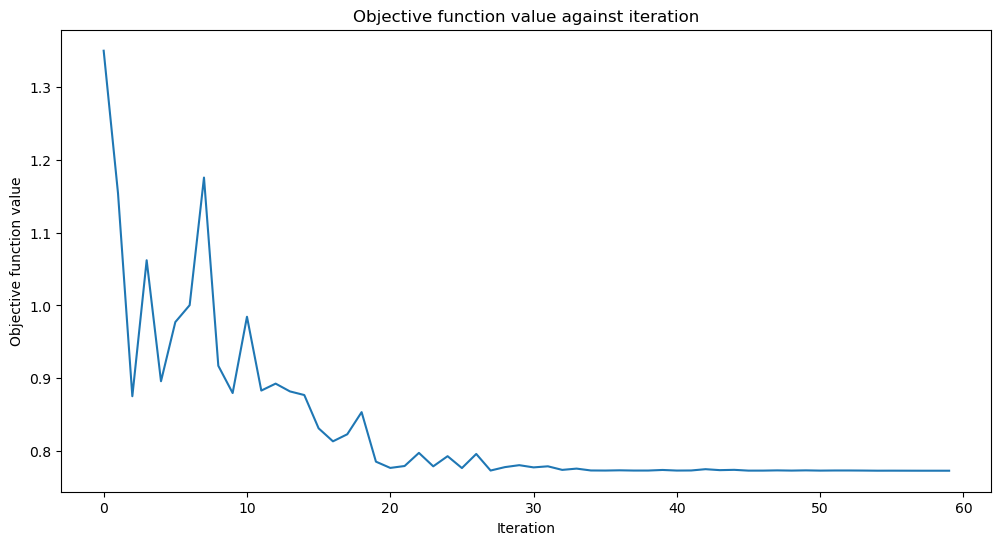

0.6

In [10]:
# Instantiation of empty callback array
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Execution
estimator_classifier.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)
estimator_classifier.score(X, y)

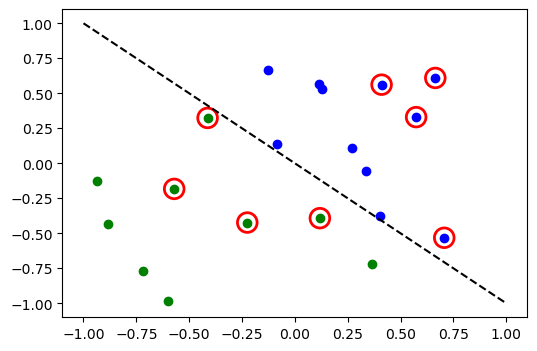

In [11]:
# Predictions
y_predict = estimator_classifier.predict(X)

# plotting results -- red == wrongly classified 
for x, y_target, y_p in zip(X, y, y_predict): 
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else: 
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidth=2)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [12]:
estimator_classifier.weights

array([ 1.74518004,  1.16608075, -0.06491181,  1.15621855,  0.99949787,
        1.10950119,  0.39840699,  1.20917712])

## Classification with `SamplerQNN`

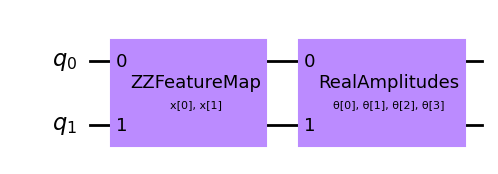

In [14]:
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw("mpl", style="clifford")

In [15]:
# parity map bitstrings to either 0 or 1 
def parity(x): 
    return "{:b}".format(x).count("1")%2

output_shape = 2 # number of classes, possible outcomes of the parity mapping

In [16]:
# constructing QNN
sampler_qnn = SamplerQNN(circuit=qc, interpret=parity, output_shape=output_shape,)

In [17]:
# constructing a classifier 
sampler_classifier = NeuralNetworkClassifier(neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph)

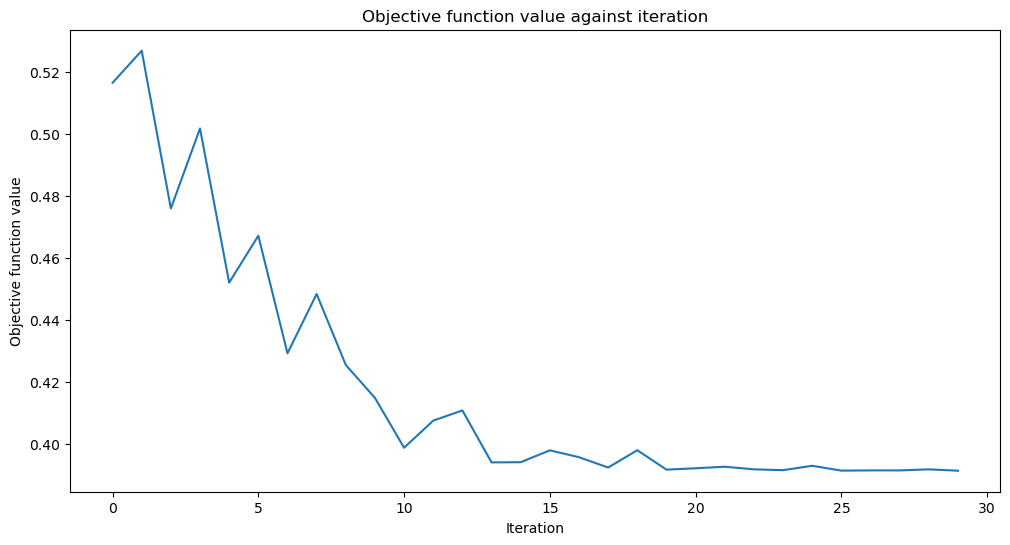

0.6

In [18]:
# Instantiation of empty callback array
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Execution
sampler_classifier.fit(X, y01)
plt.rcParams["figure.figsize"] = (6, 4)
sampler_classifier.score(X, y01)

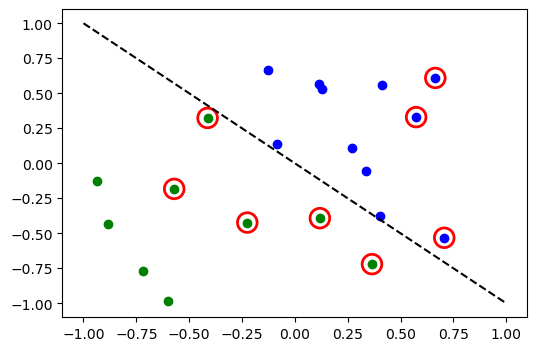

In [26]:
# Predictions
y_predict = sampler_classifier.predict(X)

# plotting results -- red == wrongly classified 
for x, y_target, y_p in zip(X, y01, y_predict): 
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else: 
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidth=2)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [21]:
sampler_classifier.weights 

array([-0.38271236,  2.1351622 ,  0.29082431,  1.30412988])

## Variational Quantum Classifier (VQC)

In [24]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# constructing variational quantum classifier 
vqc = VQC(feature_map=feature_map, ansatz=ansatz, loss="cross_entropy", optimizer=COBYLA(maxiter=30), callback=callback_graph,)

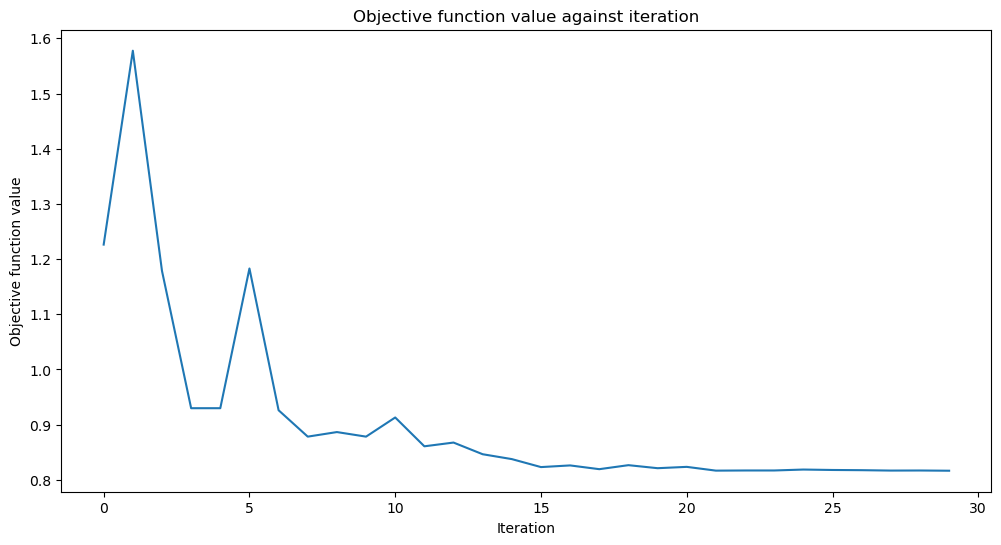

0.6

In [25]:
# Instantiation of empty callback array
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Execution
vqc.fit(X, y_one_hat)
plt.rcParams["figure.figsize"] = (6, 4)
vqc.score(X, y_one_hat)

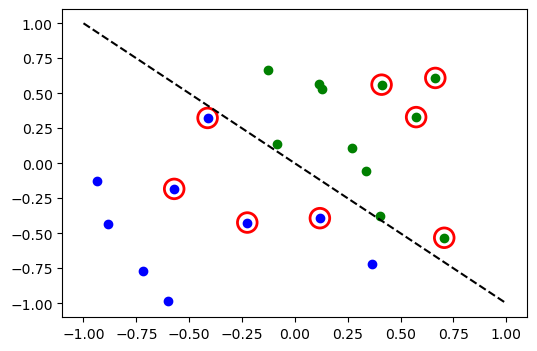

In [30]:
# Predictions
y_predict = vqc.predict(X)

# plotting results -- red == wrongly classified 
for x, y_target, y_p in zip(X, y_one_hat, y_predict): 
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else: 
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
        
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Multiple classes with VQC

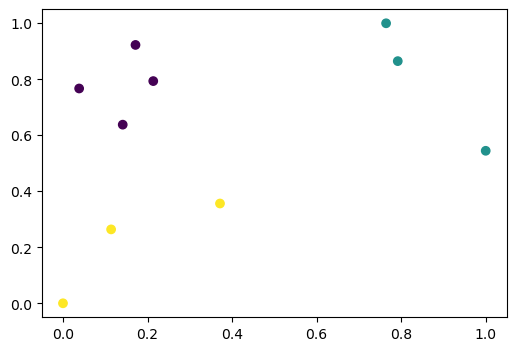

In [32]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(n_samples=10, n_features=2, n_classes=3, n_redundant=0, n_clusters_per_class=1, class_sep=2.0, random_state=algorithm_globals.random_seed,)
X = MinMaxScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [33]:
y_cat = np.empty(y.shape, dtype=str)
y_cat[y==0] = "A"
y_cat[y==1] = "B"
y_cat[y==2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


In [34]:
# constructing Variational Quantum Classifier
vqc = VQC(num_qubits=2, optimizer=COBYLA(maxiter=30), callback=callback_graph,)

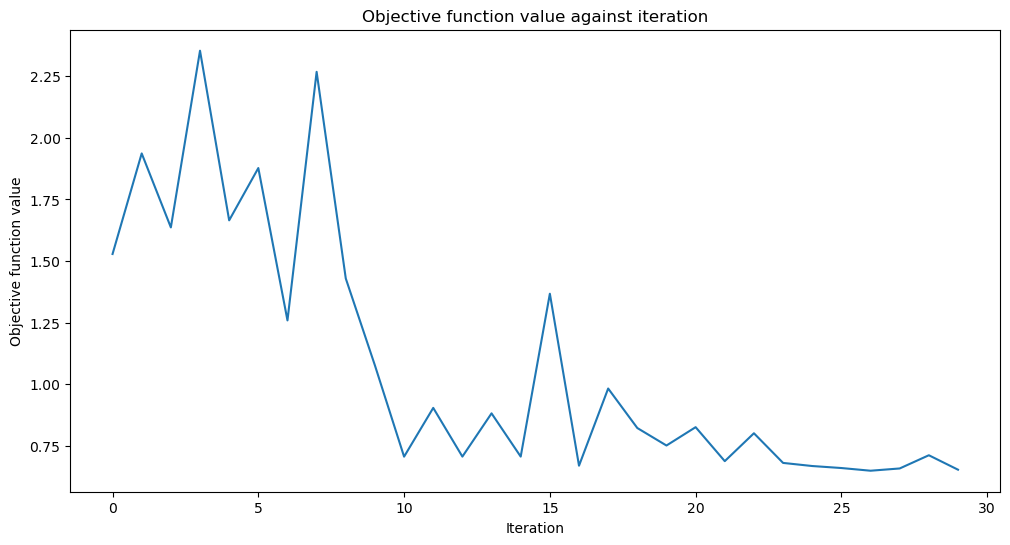

1.0

In [35]:
# Instantiation of empty callback array
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Execution
vqc.fit(X, y_cat)
plt.rcParams["figure.figsize"] = (6, 4)
vqc.score(X, y_cat)

In [36]:
# predictions
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth: {y_cat}")

Predicted labels: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']
Ground truth: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


# Regression

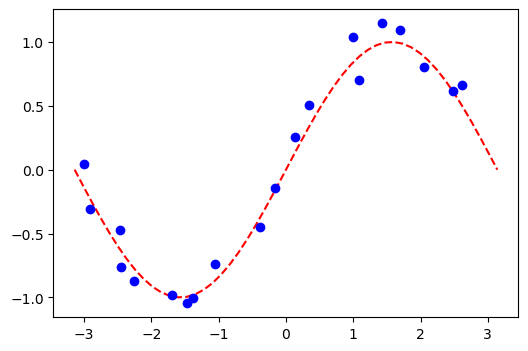

In [38]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb)*algorithm_globals.random.random([num_samples, 1]) + lb 
y = f(X[:, 0]) + eps*(2*algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

## Regressor with `EstimatorQNN`

In [39]:
# constructing a feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# constructing ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# constructing a circuit 
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# constructing QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)

In [40]:
# constructing the regressor 
regressor = NeuralNetworkRegressor(neural_network=regression_estimator_qnn, loss="squared_error", optimizer=L_BFGS_B(maxiter=5), callback=callback_graph,)

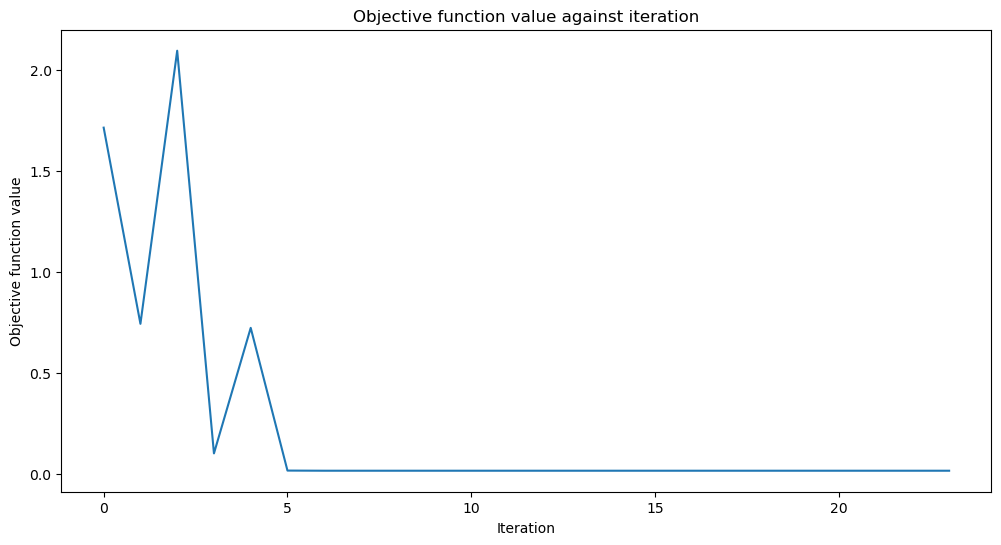

0.9737639129251995

In [41]:
# Instantiation of empty callback array
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Execution
regressor.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)
regressor.score(X, y)

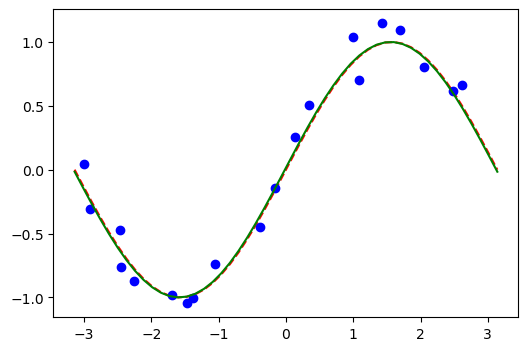

In [42]:
# plotting target function
plt.plot(X_, f(X_), "r--")

# plotting data and fitted line
plt.plot(X, y, "bo")
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [43]:
regressor.weights

array([-1.55488928])

## Regression with Variational Quantum Regressor (VQR)

In [44]:
# constructing variational quantum regressor
vqr = VQR(feature_map=feature_map, ansatz=ansatz, optimizer=L_BFGS_B(maxiter=5), callback=callback_graph,)

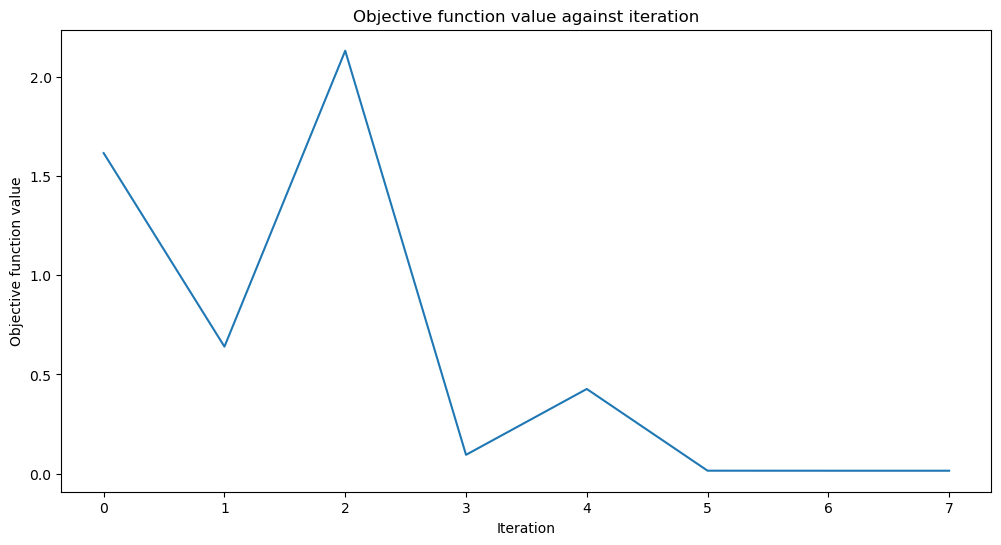

0.9737639130380663

In [45]:
# Instantiation of empty callback array
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Execution
vqr.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)
vqr.score(X, y)

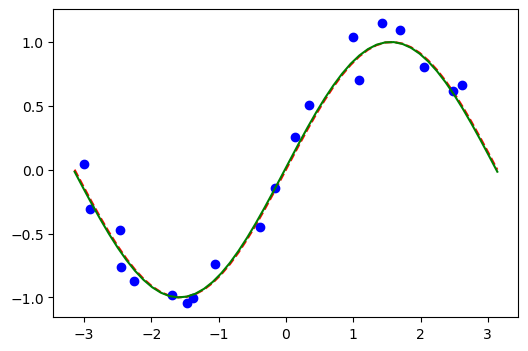

In [46]:
# plotting target function
plt.plot(X_, f(X_), "r--")

# plotting data and fitted line
plt.plot(X, y, "bo")
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()